<a href="https://colab.research.google.com/github/sailorcosmos101/Deeplearning_KU_2023/blob/main/PINN_1208.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [2]:
!tf_upgrade_v2 --infile SteadyFlowCylinder_mixed.py --outfile spgraded.py

2023-12-07 19:12:28.085564: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 19:12:28.085680: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 19:12:28.085722: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-07 19:12:29.600282: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Traceback (most recent call last):
  File "/usr/local/bin/tf_upgrade_v2", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/tools/compatibility/tf_upgrade_v2_main.py", line 156, in main
  

In [ ]:
!pip install --upgrade pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18168 sha256=5765c173277c944eedd0e4f9250f347d8f1c4a391e4ec4457ed3dc3ec54e9970
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


In [ ]:
import numpy as np
import time
from pyDOE import lhs
import matplotlib

import matplotlib.pyplot as plt
import pickle
import scipy.io
import random

tf.compat.v1.disable_eager_execution()
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # CPU:-1; GPU0: 1; GPU1: 0;

random.seed(1111)
np.random.seed(1111)
tf.compat.v1.set_random_seed(1111)

In [ ]:
class PINN_laminar_flow:
    # Initialize the class
    def __init__(self, Collo, INLET, OUTLET, WALL, uv_layers, lb, ub, ExistModel=0, uvDir=''):

        # Count for callback function
        self.count=0

        # Bounds
        self.lb = lb
        self.ub = ub

        # Mat. properties
        self.rho = 1.0
        self.mu = 0.02

        # Collocation point
        self.x_c = Collo[:, 0:1]
        self.y_c = Collo[:, 1:2]

        self.x_INLET = INLET[:, 0:1]
        self.y_INLET = INLET[:, 1:2]
        self.u_INLET = INLET[:, 2:3]
        self.v_INLET = INLET[:, 3:4]

        self.x_OUTLET = OUTLET[:, 0:1]
        self.y_OUTLET = OUTLET[:, 1:2]

        self.x_WALL = WALL[:, 0:1]
        self.y_WALL = WALL[:, 1:2]

        # Define layers
        self.uv_layers = uv_layers

        self.loss_rec = []

        # Initialize NNs
        if ExistModel== 0 :
            self.uv_weights, self.uv_biases = self.initialize_NN(self.uv_layers)
        else:
            print("Loading uv NN ...")
            self.uv_weights, self.uv_biases = self.load_NN(uvDir, self.uv_layers)

        # tf placeholders
        self.learning_rate = tf.compat.v1.placeholder(tf.float32, shape=[])
        self.x_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.x_c.shape[1]])
        self.y_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.y_c.shape[1]])

        self.x_WALL_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.x_WALL.shape[1]])
        self.y_WALL_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.y_WALL.shape[1]])

        self.x_OUTLET_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.x_OUTLET.shape[1]])
        self.y_OUTLET_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.y_OUTLET.shape[1]])

        self.x_INLET_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.x_INLET.shape[1]])
        self.y_INLET_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.y_INLET.shape[1]])
        self.u_INLET_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.u_INLET.shape[1]])
        self.v_INLET_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.v_INLET.shape[1]])

        self.x_c_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.x_c.shape[1]])
        self.y_c_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.y_c.shape[1]])

        # tf graphs
        self.u_pred, self.v_pred, self.p_pred, _, _, _, self.c_pred = self.net_uv(self.x_tf, self.y_tf)
        self.f_pred_u, self.f_pred_v, self.f_pred_s11, self.f_pred_s22, self.f_pred_s12, \
            self.f_pred_p, self.f_pred_c = self.net_f(self.x_c_tf, self.y_c_tf)
        self.u_WALL_pred, self.v_WALL_pred, _, _, _, _, _ = self.net_uv(self.x_WALL_tf, self.y_WALL_tf)
        self.u_INLET_pred, self.v_INLET_pred, _, _, _, _, _ = self.net_uv(self.x_INLET_tf, self.y_INLET_tf)
        _, _, self.p_OUTLET_pred, _, _, _, _ = self.net_uv(self.x_OUTLET_tf, self.y_OUTLET_tf)

        self.loss_f = tf.reduce_mean(tf.square(self.f_pred_u)) \
                      + tf.reduce_mean(tf.square(self.f_pred_v))\
                      + tf.reduce_mean(tf.square(self.f_pred_s11))\
                      + tf.reduce_mean(tf.square(self.f_pred_s22))\
                      + tf.reduce_mean(tf.square(self.f_pred_s12))\
                      + tf.reduce_mean(tf.square(self.f_pred_p))
        self.loss_WALL = tf.reduce_mean(tf.square(self.u_WALL_pred)) \
                       + tf.reduce_mean(tf.square(self.v_WALL_pred))
        self.loss_INLET = tf.reduce_mean(tf.square(self.u_INLET_pred-self.u_INLET_tf)) \
                         + tf.reduce_mean(tf.square(self.v_INLET_pred-self.v_INLET_tf))
        self.loss_OUTLET = tf.reduce_mean(tf.square(self.p_OUTLET_pred))

        self.loss_conc = tf.reduce_mean(tf.square(self.f_pred_c))

        self.loss = self.loss_f + 1*(self.loss_WALL + self.loss_INLET + self.loss_OUTLET )+ 2*self.loss_conc

        # Optimizer for solution

        self.optimizer_Adam = tf.compat.v1.train.AdamOptimizer(learning_rate = self.learning_rate)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss, var_list=self.uv_weights + self.uv_biases)

        # tf session
        self.sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        init = tf.compat.v1.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev, dtype=tf.float32), dtype=tf.float32)


    def save_NN(self, fileDir):

        uv_weights = self.sess.run(self.uv_weights)
        uv_biases = self.sess.run(self.uv_biases)

        with open(fileDir, 'wb') as f:
            pickle.dump([uv_weights, uv_biases], f)
            print("Save uv NN parameters successfully...")

    def load_NN(self, fileDir, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        with open(fileDir, 'rb') as f:
            uv_weights, uv_biases = pickle.load(f)

            # Stored model must has the same # of layers
            assert num_layers == (len(uv_weights)+1)

            for num in range(0, num_layers - 1):
                W = tf.Variable(uv_weights[num], dtype=tf.float32)
                b = tf.Variable(uv_biases[num], dtype=tf.float32)
                weights.append(W)
                biases.append(b)
                print(" - Load NN parameters successfully...")
        return weights, biases

    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        H = X
        # H = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def net_uv(self, x, y):
        psips = self.neural_net(tf.concat([x, y], 1), self.uv_weights, self.uv_biases)
        psi = psips[:,0:1]
        p = psips[:,1:2]
        s11 = psips[:, 2:3]
        s22 = psips[:, 3:4]
        s12 = psips[:, 4:5]
        u = tf.gradients(psi, y)[0]
        v = -tf.gradients(psi, x)[0]
        c = psips[:,5:6]
        return u, v, p, s11, s22, s12, c

    def net_f(self, x, y):

        rho=self.rho
        mu=self.mu
        u, v, p, s11, s22, s12, c = self.net_uv(x, y)

        s11_1 = tf.gradients(s11, x)[0]
        s12_2 = tf.gradients(s12, y)[0]
        s22_2 = tf.gradients(s22, y)[0]
        s12_1 = tf.gradients(s12, x)[0]

        # Plane stress problem
        u_x = tf.gradients(u, x)[0]
        u_y = tf.gradients(u, y)[0]

        v_x = tf.gradients(v, x)[0]
        v_y = tf.gradients(v, y)[0]

        # f_u:=Sxx_x+Sxy_y
        f_u = rho*(u*u_x + v*u_y) - s11_1 - s12_2
        f_v = rho*(u*v_x + v*v_y) - s12_1 - s22_2

        # f_mass = u_x+v_y

        f_s11 = -p + 2*mu*u_x - s11
        f_s22 = -p + 2*mu*v_y - s22
        f_s12 = mu*(u_y+v_x) - s12

        f_p = p + (s11+s22)/2

        # conc = diffusion + advection
        D_x = 0.003
        D_y = 0.001

        c_x = tf.gradients(c, x)[0]
        c_y = tf.gradients(c, y)[0]

        c_x2 = tf.gradients(c_x, x)[0]
        c_y2 = tf.gradients(c_y, y)[0]

        f_c = D_x * c_x2 + D_y * c_y2 - (v_x * c_x + v_y * c_y)

        return f_u, f_v, f_s11, f_s22, f_s12, f_p, f_c


    def callback(self, loss):
        self.count = self.count+1
        self.loss_rec.append(loss)
        print('{} th iterations, Loss: {}'.format(self.count, loss))


    def train(self, iter, learning_rate):
      # conc 관련 추가해야 할수도
        tf_dict = {self.x_c_tf: self.x_c, self.y_c_tf: self.y_c,
                   self.x_WALL_tf: self.x_WALL, self.y_WALL_tf: self.y_WALL,
                   self.x_INLET_tf: self.x_INLET, self.y_INLET_tf: self.y_INLET, self.u_INLET_tf: self.u_INLET, self.v_INLET_tf: self.v_INLET,
                   self.x_OUTLET_tf: self.x_OUTLET, self.y_OUTLET_tf: self.y_OUTLET,
                   self.learning_rate: learning_rate}

        loss_WALL = []
        loss_f = []
        loss_INLET = []
        loss_OUTLET = []
        loss_conc = []

        for it in range(iter):

            self.sess.run(self.train_op_Adam, tf_dict)

            # Print
            if it % 10 == 0:
                loss_value = self.sess.run(self.loss, tf_dict)
                print('It: %d, Loss: %.3e' %
                      (it, loss_value))

            loss_WALL.append(self.sess.run(self.loss_WALL, tf_dict))
            loss_f.append(self.sess.run(self.loss_f, tf_dict))
            self.loss_rec.append(self.sess.run(self.loss, tf_dict))
            loss_INLET.append(self.sess.run(self.loss_INLET, tf_dict))
            loss_OUTLET.append(self.sess.run(self.loss_OUTLET, tf_dict))
            loss_conc.append(self.sess.run(self.loss_conc,tf_dict))

        return loss_WALL, loss_INLET, loss_OUTLET, loss_f, loss_conc, self.loss

    def train_bfgs(self):

        tf_dict = {self.x_c_tf: self.x_c, self.y_c_tf: self.y_c,
                   self.x_WALL_tf: self.x_WALL, self.y_WALL_tf: self.y_WALL,
                   self.x_INLET_tf: self.x_INLET, self.y_INLET_tf: self.y_INLET, self.u_INLET_tf: self.u_INLET, self.v_INLET_tf: self.v_INLET,
                   self.x_OUTLET_tf: self.x_OUTLET, self.y_OUTLET_tf: self.y_OUTLET}

        self.optimizer.minimize(self.sess,
                                feed_dict=tf_dict,
                                fetches=[self.loss],
                                loss_callback=self.callback)

    def predict(self, x_star, y_star):
        u_star = self.sess.run(self.u_pred, {self.x_tf: x_star, self.y_tf: y_star})
        v_star = self.sess.run(self.v_pred, {self.x_tf: x_star, self.y_tf: y_star})
        p_star = self.sess.run(self.p_pred, {self.x_tf: x_star, self.y_tf: y_star})
        c_star = self.sess.run(self.c_pred, {self.x_tf: x_star, self.y_tf: y_star})
        return u_star, v_star, p_star, c_star

    def getloss(self):

        tf_dict = {self.x_c_tf: self.x_c, self.y_c_tf: self.y_c,
                   self.x_WALL_tf: self.x_WALL, self.y_WALL_tf: self.y_WALL,
                   self.x_INLET_tf: self.x_INLET, self.y_INLET_tf: self.y_INLET, self.u_INLET_tf: self.u_INLET, self.v_INLET_tf: self.v_INLET,
                   self.x_OUTLET_tf: self.x_OUTLET, self.y_OUTLET_tf: self.y_OUTLET}

        loss_f = self.sess.run(self.loss_f, tf_dict)
        loss_WALL = self.sess.run(self.loss_WALL, tf_dict)
        loss_INLET = self.sess.run(self.loss_INLET, tf_dict)
        loss = self.sess.run(self.loss, tf_dict)
        loss_OUTLET = self.sess.run(self.loss_OUTLET, tf_dict)
        loss_conc = self.sess.run(self.loss_conc, tf_dict)

        return loss_WALL, loss_INLET, loss_OUTLET, loss_f, loss

In [ ]:
def DelCylPT(XY_c, xc=0.0, yc=0.0, r=0.1):
    '''
    delete points within cylinder
    '''
    dst = np.array([((xy[0] - xc) ** 2 + (xy[1] - yc) ** 2) ** 0.5 for xy in XY_c])
    return XY_c[dst>r,:]

In [ ]:
def postProcess(xmin, xmax, ymin, ymax, field_MIXED, s=2, alpha=0.5, marker='o'):
    # c_PINN 출력 어떻게
    # [x_FLUENT, y_FLUENT, u_FLUENT, v_FLUENT, p_FLUENT, c_FLUENT] = field_FLUENT
    [x_MIXED, y_MIXED, u_MIXED, v_MIXED, p_MIXED, c_FLUENT] = field_MIXED

    fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(14,10))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    # Plot MIXED result
    cf = ax[0, 0].scatter(x_MIXED, y_MIXED, c=u_MIXED, alpha=alpha-0.1, edgecolors='none', cmap='rainbow', marker=marker, s=int(s))
    ax[0, 0].axis('square')
    for key, spine in ax[0, 0].spines.items():
        if key in ['right','top','left','bottom']:
            spine.set_visible(False)
    ax[0, 0].set_xticks([])
    ax[0, 0].set_yticks([])
    ax[0, 0].set_xlim([xmin, xmax])
    ax[0, 0].set_ylim([ymin, ymax])
    ax[0, 0].set_title(r'$u$ (m/s)')
    fig.colorbar(cf, ax=ax[0, 0], fraction=0.046, pad=0.04)

    cf = ax[1, 0].scatter(x_MIXED, y_MIXED, c=v_MIXED, alpha=alpha-0.1, edgecolors='none', cmap='rainbow', marker=marker, s=int(s))
    ax[1, 0].axis('square')
    for key, spine in ax[1, 0].spines.items():
        if key in ['right','top','left','bottom']:
            spine.set_visible(False)
    ax[1, 0].set_xticks([])
    ax[1, 0].set_yticks([])
    ax[1, 0].set_xlim([xmin, xmax])
    ax[1, 0].set_ylim([ymin, ymax])
    ax[1, 0].set_title(r'$v$ (m/s)')
    fig.colorbar(cf, ax=ax[1, 0], fraction=0.046, pad=0.04)

    cf = ax[2, 0].scatter(x_MIXED, y_MIXED, c=p_MIXED, alpha=alpha, edgecolors='none', cmap='rainbow', marker=marker, s=int(s), vmin=-0.25, vmax=4.0)
    ax[2, 0].axis('square')
    for key, spine in ax[2, 0].spines.items():
        if key in ['right','top','left','bottom']:
            spine.set_visible(False)
    ax[2, 0].set_xticks([])
    ax[2, 0].set_yticks([])
    ax[2, 0].set_xlim([xmin, xmax])
    ax[2, 0].set_ylim([ymin, ymax])
    ax[2, 0].set_title('Pressure (Pa)')
    fig.colorbar(cf, ax=ax[2, 0], fraction=0.046, pad=0.04)

    cf = ax[3,0].scatter(x_MIXED, y_MIXED, c=p_MIXED, alpha=alpha, edgecolors='none', cmap='rainbow', marker=marker, s=int(s), vmin=-0.25, vmax=4.0)
    ax[3, 0].axis('square')
    for key, spine in ax[3, 0].spines.items():
        if key in ['right','top','left','bottom']:
            spine.set_visible(False)
    ax[3, 0].set_xticks([])
    ax[3, 0].set_yticks([])
    ax[3, 0].set_xlim([xmin, xmax])
    ax[3, 0].set_ylim([ymin, ymax])
    ax[3, 0].set_title('Concentration')
    fig.colorbar(cf, ax=ax[3, 0], fraction=0.046, pad=0.04)


    plt.savefig('./uvp.png', dpi=300)
    plt.close('all')
'''
    # Plot FLUENT result
    cf = ax[0, 1].scatter(x_FLUENT, y_FLUENT, c=u_FLUENT, alpha=alpha, edgecolors='none', cmap='rainbow', marker=marker, s=s)
    ax[0, 1].axis('square')
    for key, spine in ax[0, 1].spines.items():
        if key in ['right','top','left','bottom']:
            spine.set_visible(False)
    ax[0, 1].set_xticks([])
    ax[0, 1].set_yticks([])
    ax[0, 1].set_xlim([xmin, xmax])
    ax[0, 1].set_ylim([ymin, ymax])
    ax[0, 1].set_title(r'$u$ (m/s)')
    fig.colorbar(cf, ax=ax[0, 1], fraction=0.046, pad=0.04)

    cf = ax[1, 1].scatter(x_FLUENT, y_FLUENT, c=v_FLUENT, alpha=alpha, edgecolors='none', cmap='rainbow', marker=marker, s=s)
    ax[1, 1].axis('square')
    for key, spine in ax[1, 1].spines.items():
        if key in ['right','top','left','bottom']:
            spine.set_visible(False)
    ax[1, 1].set_xticks([])
    ax[1, 1].set_yticks([])
    ax[1, 1].set_xlim([xmin, xmax])
    ax[1, 1].set_ylim([ymin, ymax])
    ax[1, 1].set_title(r'$v$ (m/s)')
    fig.colorbar(cf, ax=ax[1, 1], fraction=0.046, pad=0.04)

    cf = ax[2, 1].scatter(x_FLUENT, y_FLUENT, c=p_FLUENT, alpha=alpha, edgecolors='none', cmap='rainbow', marker=marker, s=s, vmin=-0.25, vmax=4.0)
    ax[2, 1].axis('square')
    for key, spine in ax[2, 1].spines.items():
        if key in ['right','top','left','bottom']:
            spine.set_visible(False)
    ax[2, 1].set_xticks([])
    ax[2, 1].set_yticks([])
    ax[2, 1].set_xlim([xmin, xmax])
    ax[2, 1].set_ylim([ymin, ymax])
    ax[2, 1].set_title('Pressure (Pa)')
    fig.colorbar(cf, ax=ax[2, 1], fraction=0.046, pad=0.04)

    cf = ax[3, 1].scatter(x_MIXED, y_MIXED, c=p_MIXED, alpha=alpha, edgecolors='none', cmap='rainbow', marker=marker, s=int(s), vmin=-0.25, vmax=4.0)
    ax[3, 1].axis('square')
    for key, spine in ax[3, 1].spines.items():
        if key in ['right','top','left','bottom']:
            spine.set_visible(False)
    ax[3, 1].set_xticks([])
    ax[3, 1].set_yticks([])
    ax[3, 1].set_xlim([xmin, xmax])
    ax[3, 1].set_ylim([ymin, ymax])
    ax[3, 1].set_title('Concentration')
    fig.colorbar(cf, ax=ax[3, 1], fraction=0.046, pad=0.04)
'''


"\n    # Plot FLUENT result\n    cf = ax[0, 1].scatter(x_FLUENT, y_FLUENT, c=u_FLUENT, alpha=alpha, edgecolors='none', cmap='rainbow', marker=marker, s=s)\n    ax[0, 1].axis('square')\n    for key, spine in ax[0, 1].spines.items():\n        if key in ['right','top','left','bottom']:\n            spine.set_visible(False)\n    ax[0, 1].set_xticks([])\n    ax[0, 1].set_yticks([])\n    ax[0, 1].set_xlim([xmin, xmax])\n    ax[0, 1].set_ylim([ymin, ymax])\n    ax[0, 1].set_title(r'$u$ (m/s)')\n    fig.colorbar(cf, ax=ax[0, 1], fraction=0.046, pad=0.04)\n\n    cf = ax[1, 1].scatter(x_FLUENT, y_FLUENT, c=v_FLUENT, alpha=alpha, edgecolors='none', cmap='rainbow', marker=marker, s=s)\n    ax[1, 1].axis('square')\n    for key, spine in ax[1, 1].spines.items():\n        if key in ['right','top','left','bottom']:\n            spine.set_visible(False)\n    ax[1, 1].set_xticks([])\n    ax[1, 1].set_yticks([])\n    ax[1, 1].set_xlim([xmin, xmax])\n    ax[1, 1].set_ylim([ymin, ymax])\n    ax[1, 1].set_t

In [ ]:
def preprocess(dir='FenicsSol.mat'):
    '''
    Load reference solution from Fenics or Fluent
    '''
    data = scipy.io.loadmat(dir)

    X = data['x']
    Y = data['y']
    P = data['p']
    vx = data['vx']
    vy = data['vy']
    c = data['c']

    x_star = X.flatten()[:, None]
    y_star = Y.flatten()[:, None]
    p_star = P.flatten()[:, None]
    vx_star = vx.flatten()[:, None]
    vy_star = vy.flatten()[:, None]
    c_star = c.flatten()[:,None]

    return x_star, y_star, vx_star, vy_star, p_star, c_star

In [ ]:
def multiple_formatter(denominator=2, number=np.pi, latex='\pi'):
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    def _multiple_formatter(x, pos):
        den = denominator
        num = np.int(np.rint(den*x/number))
        com = gcd(num,den)
        (num,den) = (int(num/com),int(den/com))
        if den==1:
            if num==0:
                return r'$0$'
            if num==1:
                return r'$%s$'%latex
            elif num==-1:
                return r'$-%s$'%latex
            else:
                return r'$%s%s$'%(num,latex)
        else:
            if num==1:
                return r'$\frac{%s}{%s}$'%(latex,den)
            elif num==-1:
                return r'$\frac{-%s}{%s}$'%(latex,den)
            else:
                return r'$\frac{%s%s}{%s}$'%(num,latex,den)
    return _multiple_formatter

In [ ]:
class Multiple:
    def __init__(self, denominator=2, number=np.pi, latex='\pi'):
        self.denominator = denominator
        self.number = number
        self.latex = latex

    def locator(self):
        return plt.MultipleLocator(self.number / self.denominator)

    def formatter(self):
        return plt.FuncFormatter(multiple_formatter(self.denominator, self.number, self.latex))

(49154, 2)


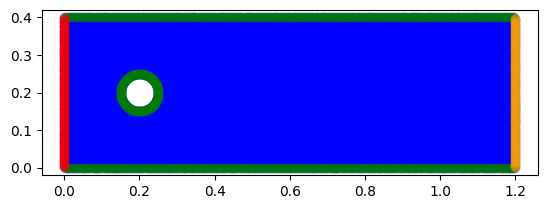

In [ ]:
if __name__ == "__main__":

    # Domain bounds
    lb = np.array([0, 0])
    ub = np.array([1.2, 0.40])

    # Network configuration
    uv_layers = [2] + 8*[50] + [5]

    # WALL = [x, y], u=v=0
    wall_up = [0.0, 0.40] + [1.2, 0.0] * lhs(2, 441)
    wall_lw = [0.0, 0.00] + [1.2, 0.0] * lhs(2, 441)

    # INLET = [x, y, u, v]
    U_max = 1.0
    INLET = [0.0, 0.0] + [0.0, 0.40] * lhs(2, 201)
    y_INLET = INLET[:,1:2]
    u_INLET = 4*U_max*y_INLET*(0.40-y_INLET)/(0.40**2)
    v_INLET = 0*y_INLET
    INLET = np.concatenate((INLET, u_INLET, v_INLET), 1)

    # plt.scatter(INLET[:, 1:2], INLET[:, 2:3], marker='o', alpha=0.2, color='red')
    # plt.show()

    # INLET = [x, y], p=0
    OUTLET = [1.2, 0.0] + [0.0, 0.40] * lhs(2, 201)

    # Cylinder surface
    r = 0.05
    theta = [0.0] + [2*np.pi] * lhs(1, 251)
    x_CYLD = np.multiply(r, np.cos(theta))+0.2
    y_CYLD = np.multiply(r, np.sin(theta))+0.2
    CYLD = np.concatenate((x_CYLD, y_CYLD), 1)

    WALL = np.concatenate((CYLD, wall_up, wall_lw), 0)

    # Collocation point for equation residual
    XY_c = lb + (ub - lb) * lhs(2, 40000)
    XY_c_refine = [0.1, 0.1] + [0.2, 0.2] * lhs(2, 10000)
    XY_c = np.concatenate((XY_c, XY_c_refine), 0)
    XY_c = DelCylPT(XY_c, xc=0.2, yc=0.2, r=0.05)

    XY_c = np.concatenate((XY_c, WALL, CYLD, OUTLET, INLET[:,0:2]), 0)

    c = np.zeros(49154)[:, None]
    c[1425] = 100

    print(XY_c.shape)

    # Visualize the collocation points
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    plt.scatter(XY_c[:,0:1], XY_c[:,1:2], marker='o', alpha=0.1 ,color='blue')
    plt.scatter(WALL[:,0:1], WALL[:,1:2], marker='o', alpha=0.2 , color='green')
    plt.scatter(OUTLET[:, 0:1], OUTLET[:, 1:2], marker='o', alpha=0.2, color='orange')
    plt.scatter(INLET[:, 0:1], INLET[:, 1:2], marker='o', alpha=0.2, color='red')
    plt.show()

In [ ]:
    with tf.device('/device:GPU:0'):
        config = tf.compat.v1.ConfigProto()
        config.gpu_options.allow_growth = True
        session = tf.compat.v1.Session(config=config)

        # Train from scratch
        model = PINN_laminar_flow(XY_c, INLET, OUTLET, WALL, uv_layers, lb, ub)
        # Load trained neural network
        # model = PINN_laminar_flow(XY_c, INLET, OUTLET, WALL, uv_layers, lb, ub, ExistModel = 0, uvDir = 'DL_test.xlsx')

        start_time = time.time()
        loss_WALL, loss_INLET, loss_OUTLET, loss_f,loss_conc, loss = model.train(iter=10000, learning_rate=5e-4)
        # model.train_bfgs()
        print("--- %s seconds ---" % (time.time() - start_time))

        # Save neural network
        model.save_NN('drive/MyDrive/uvNN.pickle')

        # Save loss history
        with open('drive/MyDrive/loss_history.pickle', 'wb') as f:
            pickle.dump(model.loss_rec, f)

Device mapping: no known devices.
It: 0, Loss: 6.203e-01
It: 10, Loss: 3.360e-01
It: 20, Loss: 3.165e-01
It: 30, Loss: 3.089e-01


KeyboardInterrupt: ignored

In [ ]:
        x_PINN = np.linspace(0, 1.2, 251)
        y_PINN = np.linspace(0, 0.40, 101)
        x_PINN, y_PINN = np.meshgrid(x_PINN, y_PINN)
        x_PINN = x_PINN.flatten()[:, None]
        y_PINN = y_PINN.flatten()[:, None]
        dst = ((x_PINN-0.2)**2+(y_PINN-0.2)**2)**0.5
        x_PINN = x_PINN[dst >= 0.05]
        y_PINN = y_PINN[dst >= 0.05]
        x_PINN = x_PINN.flatten()[:, None]
        y_PINN = y_PINN.flatten()[:, None]

        index_1m_0_6m = np.where((x_PINN == 1.0) & (y_PINN == 0.6))[0]

        u_PINN, v_PINN, p_PINN, c_PINN = model.predict(x_PINN, y_PINN)
        field_MIXED = [x_PINN, y_PINN, u_PINN, v_PINN, p_PINN, c_PINN]

        # Plot the comparison of u, v, p, c
        postProcess(xmin=0, xmax=1.2, ymin=0, ymax=0.40, field_MIXED=field_MIXED, s=3, alpha=0.5)



In [ ]:
import pandas

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/loss_history_2_1.pickle', 'rb') as f:
    data_2_1 = pickle.load(f)
data_2_1[10000]

IndexError: ignored